In [1]:
import pandas as pd
import numpy as np
from src import util
from src.process2014_2017 import ProcessEnade2014_2017
from src.process2011 import ProcessEnade2011
from src.process2008 import ProcessEnade2008
from src.process2005 import ProcessEnade2005
from src import config
from src import subject_manipulation
from typing import Tuple, List
from src.config import SUBJECT_DF_PATH, BLANK_LABEL, DELETION_LABEL, CANCELLED_LABEL, DIFFICULTIES
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
subject_df = subject_manipulation.get_processed_subject_df(SUBJECT_DF_PATH)

In [3]:
def get_display_df(year: int, input_df: pd.DataFrame,
                   subject_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    temp_subject_df = subject_df.loc[subject_df['ano'] == year].copy()
    
    util.map_presence(input_df)
    presence_df = input_df["TP_PRES"].value_counts()
    
    input_df = util.filter_present_students(input_df)
    subjects = util.get_subjects(temp_subject_df)
    input_df = util.add_all_score_categories(input_df, temp_subject_df, True, 
                                           subjects, util.get_subject_valid_questions)
    
    num_questions = []
    mean_acertos_by_subject = []
    std_acertos_by_subject = []
    column_zero_subject = []
    column_geq_one_subject = []
    column_all_subject = []
    num_alunos = input_df.shape[0]

    

    
    for subject in subjects:
        subject_questions = util.get_subject_valid_questions(subject, 
                                                                 temp_subject_df,
                                                                 input_df,
                                                                 just_objective=True)
        num_obj_subject_questions = len(subject_questions)
    
    
    
        mean_acertos_subject = input_df[f"ACERTOS_OBJ_{subject}"].mean()
    
        std_acertos_subject = input_df[f"ACERTOS_OBJ_{subject}"].std()
    
        zero_subject_percentage = list(input_df[f"ACERTOS_OBJ_{subject}"]).count(0) * 100 / num_alunos
    
        geq_one_subject_percentage = list(input_df[f"ACERTOS_OBJ_{subject}"] >= 1).count(True) * 100 / num_alunos
        
        all_subject_percentage = list(input_df[f"ACERTOS_OBJ_{subject}"] == num_obj_subject_questions).count(True) * 100 / num_alunos
        
        if num_obj_subject_questions > 0:
            num_questions.append(num_obj_subject_questions)
            mean_acertos_by_subject.append(mean_acertos_subject)
            std_acertos_by_subject.append(std_acertos_subject)
            column_zero_subject.append(zero_subject_percentage)
            column_geq_one_subject.append(geq_one_subject_percentage)
            column_all_subject.append(all_subject_percentage)
        else:
            num_questions.append(0)
            mean_acertos_by_subject.append(None)
            std_acertos_by_subject.append(None)
            column_zero_subject.append(None)
            column_geq_one_subject.append(None)
            column_all_subject.append(None)

    subjects_labels = [f"SCORE_OBJ_{x}" for x in subjects]

    mean_by_subject = input_df[subjects_labels].mean().values

    data = np.array([mean_by_subject, num_questions]).T

    display_df = pd.DataFrame(data=data, index=subjects, 
                          columns=["Nota %", "Nº Questões"])
    display_df["Nº Questões"] = display_df["Nº Questões"].astype(int, errors="ignore")
    display_df["Média Acertos"] = mean_acertos_by_subject
    display_df["Desvio Padrão Acertos"] = std_acertos_by_subject
    display_df["% de Zeros"] = column_zero_subject

    display_df["% de Alunos que acertaram pelo menos uma questão"] = column_geq_one_subject
    display_df["% de Alunos que acertaram todas"] = column_all_subject


    display_df = display_df.sort_values(by=["Nota %"]).round(2)

    
    return display_df, input_df, presence_df
    
    

In [4]:
def get_dict_all_years(filter_by_ufpa: bool) -> dict:
    enade_2017 = ProcessEnade2014_2017(2017).get_data(filter_by_ufpa)
    enade_2014 = ProcessEnade2014_2017(2014).get_data(filter_by_ufpa)
    enade_2011 = ProcessEnade2011().get_data(filter_by_ufpa)
    enade_2008 = ProcessEnade2008().get_data(filter_by_ufpa)
    enade_2005 = ProcessEnade2005().get_data(filter_by_ufpa)
    return {2017: enade_2017, 
            2014: enade_2014, 
            2011: enade_2011,
            2008: enade_2008,
            2005: enade_2005}

In [5]:
dfs = get_dict_all_years(filter_by_ufpa=True)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (1,5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (49,55,58,68) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (67,68,69,70,71,72,73,74,76,77,78,79,80,81,85) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [6]:

display_dfs = {}
presence_dfs = {}
for year in dfs.keys():
    enade_df = dfs[year]
    display_df, df, presence_df = get_display_df(year, enade_df, subject_df)
    dfs[year] = df
    display_dfs[year] = display_df
    presence_dfs[year] = presence_df   
    

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [7]:
print("ANO de 2017")
display_dfs[2017]


ANO de 2017


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
Teoria da computação,13.24,2,0.26,0.45,73.53,26.47,0.00
Banco de dados,30.88,2,0.62,0.55,41.18,58.82,2.94
Compiladores,32.35,1,0.32,0.47,67.65,32.35,32.35
Algoritmos e estruturas de dados,35.29,4,1.41,1.08,23.53,76.47,2.94
Arquitetura de computadores e sistemas operacionais,35.29,3,1.06,0.81,23.53,76.47,5.88
Computação gráfica e processamento de imagem,41.18,1,0.41,0.50,58.82,41.18,41.18
Sistemas distribuídos,41.18,2,0.82,0.80,41.18,58.82,23.53
Teoria dos grafos,44.12,1,0.44,0.50,55.88,44.12,44.12
Fundamentos e técnicas de programação,47.06,1,0.47,0.51,52.94,47.06,47.06
Lógica e matemática discreta,47.06,1,0.47,0.51,52.94,47.06,47.06


In [8]:
print("Ano de 2014")
display_dfs[2014]

Ano de 2014


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
Teoria dos grafos,14.29,2,0.29,0.53,75.00,25.00,3.57
Computação gráfica e processamento de imagem,17.86,1,0.18,0.39,82.14,17.86,17.86
Sistemas digitais,17.86,1,0.18,0.39,82.14,17.86,17.86
Teoria da computação,23.81,3,0.71,0.66,39.29,60.71,0.00
Paradigmas de linguagens de programação,32.14,1,0.32,0.48,67.86,32.14,32.14
Lógica e matemática discreta,34.29,5,1.71,1.12,14.29,85.71,0.00
Algoritmos e estruturas de dados,35.71,2,0.71,0.66,39.29,60.71,10.71
Compiladores,35.71,2,0.71,0.60,35.71,64.29,7.14
Fundamentos e técnicas de programação,42.86,1,0.43,0.50,57.14,42.86,42.86
Arquitetura de computadores e sistemas operacionais,75.00,1,0.75,0.44,25.00,75.00,75.00


In [9]:
print("Ano de 2011")
display_dfs[2011]

Ano de 2011


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
Paradigmas de linguagens de programação,19.61,3,0.59,0.62,47.06,52.94,0.00
Sistemas digitais,23.53,1,0.24,0.44,76.47,23.53,23.53
Fundamentos e técnicas de programação,30.88,4,1.24,0.83,17.65,82.35,0.00
Lógica e matemática discreta,31.37,3,0.94,0.97,41.18,58.82,5.88
Redes de computadores,32.35,2,0.65,0.70,47.06,52.94,11.76
Arquitetura de computadores e sistemas operacionais,35.29,2,0.71,0.47,29.41,70.59,0.00
Teoria da computação,47.06,3,1.41,0.87,11.76,88.24,11.76
Teoria dos grafos,47.06,1,0.47,0.51,52.94,47.06,47.06
Algoritmos e estruturas de dados,52.94,5,2.65,1.00,0.00,100.00,0.00
Probabilidade e estatística,58.82,1,0.59,0.51,41.18,58.82,58.82


In [10]:
print("Ano de 2008")
display_dfs[2008]

Ano de 2008


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
Banco de dados,19.44,2,0.39,0.64,69.44,30.56,8.33
Probabilidade e estatística,22.22,2,0.44,0.56,58.33,41.67,2.78
Engenharia de software e interação homem-computador,26.39,2,0.53,0.70,58.33,41.67,11.11
Compiladores,28.70,3,0.86,0.76,36.11,63.89,0.00
Algoritmos e estruturas de dados,29.17,2,0.58,0.60,47.22,52.78,5.56
Lógica e matemática discreta,29.17,2,0.58,0.60,47.22,52.78,5.56
Redes de computadores,33.33,5,1.67,1.20,13.89,86.11,0.00
Sistemas digitais,33.33,2,0.67,0.48,33.33,66.67,0.00
Teoria da computação,33.33,2,0.67,0.68,44.44,55.56,11.11
Fundamentos e técnicas de programação,36.11,1,0.36,0.49,63.89,36.11,36.11


In [11]:
print("Ano de 2005")
display_dfs[2005]

Ano de 2005


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
Sistemas digitais,13.33,1,0.13,0.35,86.67,13.33,13.33
Teoria da computação,16.67,2,0.33,0.48,66.67,33.33,0.00
Algoritmos e estruturas de dados,17.78,3,0.53,0.63,53.33,46.67,0.00
Fundamentos e técnicas de programação,22.22,3,0.67,0.76,50.00,50.00,0.00
Paradigmas de linguagens de programação,23.33,1,0.23,0.43,76.67,23.33,23.33
Computação gráfica e processamento de imagem,25.00,2,0.50,0.57,53.33,46.67,3.33
Compiladores,26.67,1,0.27,0.45,73.33,26.67,26.67
Lógica e matemática discreta,28.89,3,0.87,0.68,30.00,70.00,0.00
Redes de computadores,30.00,2,0.60,0.67,50.00,50.00,10.00
Teoria dos grafos,30.00,1,0.30,0.47,70.00,30.00,30.00


In [12]:
def display_all_years_nota(all_dfs: dict) -> pd.DataFrame:
    data = {"2005": all_dfs[2005]["Nota %"].copy(),
            "2008": all_dfs[2008]["Nota %"].copy(),
            "2011": all_dfs[2011]["Nota %"].copy(),
            "2014": all_dfs[2014]["Nota %"].copy(),
            "2017": all_dfs[2017]["Nota %"].copy()}
    return pd.DataFrame(data)

In [13]:
display_all_years_nota(display_dfs)

,2005,2008,2011,2014,2017
Algoritmos e estruturas de dados,17.78,29.17,52.94,35.71,35.29
Arquitetura de computadores e sistemas operacionais,37.78,69.44,35.29,75.00,35.29
Banco de dados,43.33,19.44,NaN,82.14,30.88
Compiladores,26.67,28.70,61.76,35.71,32.35
Computação gráfica e processamento de imagem,25.00,37.50,NaN,17.86,41.18
Engenharia de software e interação homem-computador,40.00,26.39,61.76,85.71,50.00
Fundamentos e técnicas de programação,22.22,36.11,30.88,42.86,47.06
Inteligência artificial e computacional,33.33,36.11,NaN,NaN,61.76
Lógica e matemática discreta,28.89,29.17,31.37,34.29,47.06
Paradigmas de linguagens de programação,23.33,NaN,19.61,32.14,73.53


In [14]:
presence_by_year = {"2005": presence_dfs[2005].copy(),
                    "2008": presence_dfs[2008].copy(),
                    "2011": presence_dfs[2011].copy(),
                    "2014": presence_dfs[2014].copy(),
                    "2017": presence_dfs[2017].copy()}

presence_by_year_df = pd.DataFrame(presence_by_year)
presence_by_year_df.fillna(0).astype(int)


,2005,2008,2011,2014,2017
Presente,30,36,17,28,34
Ausente,5,2,3,3,14


In [15]:
"""Numero de questões respondidas por categoria considerando todos os anos
    
    contador para cada categoria iniciado em 0
    para cada prova
        para cada categoria
            multiplicar numero de presentes pelo numero de questões da categoria
            incrementar o contador da categoria
     """

def return_num_answered(display_dfs, original_dfs):
    num_questions_answered_dfs = []
    for year in display_dfs.keys():
        df = display_dfs[year]
        num_questions = df["Nº Questões"].astype(int).copy()
        num_questions *= original_dfs[year].shape[0]
        num_questions_answered_dfs.append(num_questions)
    num_questions_answered_df = pd.concat(num_questions_answered_dfs, axis=1)
    num_answered_by_difficulty = num_questions_answered_df.fillna(0).sum(axis=1).sort_index()
    return num_answered_by_difficulty

"""Numero de questões respondidas corretamente por categoria considerando todos os anos
    
    contador para cada categoria iniciado em 0
    para cada prova
        para cada categoria
            multiplicar numero de presentes pelo numero de questões acertadas da categoria
            incrementar o contador da categoria
     """

def return_num_correct(dfs, categories):
    columns = [f"ACERTOS_OBJ_{x}" for x in categories]
    correct_by_category  = pd.concat(dfs.values(), ignore_index=True)
    correct_by_category = correct_by_category[columns].sum(0).sort_index()
    return correct_by_category
    

def get_all_years_combined_df(display_dfs, dfs, categories):
    num_answered = return_num_answered(display_dfs, dfs)
    num_correct = return_num_correct(dfs, categories)
    num_correct.index = num_answered.index
    data_df = {"Questões Respondidas no total (Questões x Alunos)": num_answered,
               "Acertos no Total (Acertos x Alunos)": num_correct}
    score_df_category = pd.DataFrame(data_df)
    score_df_category["Nota %"] = score_df_category.iloc[:, 1]*100/score_df_category.iloc[:, 0]
    score_df_category.iloc[:, 0] =  score_df_category.iloc[:, 0].astype(int)
    score_df_category.iloc[:, 1] =  score_df_category.iloc[:, 1].astype(int)

    score_df_category["Nota %"] = score_df_category["Nota %"].round(2)
    
    return score_df_category.sort_values(by=["Nota %"])

In [16]:
get_all_years_combined_df(display_dfs, dfs, util.get_subjects(subject_df))

,Questões Respondidas no total (Questões x Alunos),Acertos no Total (Acertos x Alunos),Nota %
Teoria da computação,335,87,25.97
Teoria dos grafos,137,40,29.20
Probabilidade e estatística,89,26,29.21
Computação gráfica e processamento de imagem,194,61,31.44
Fundamentos e técnicas de programação,256,82,32.03
Sistemas digitais,181,58,32.04
Lógica e matemática discreta,387,127,32.82
Algoritmos e estruturas de dados,439,150,34.17
Compiladores,262,91,34.73
Paradigmas de linguagens de programação,143,51,35.66


In [17]:
"""Numero de questões marcadas em branco e rasuradas. 
   
   A porcentagem desses valores é calculada de acordo com o numero total de questões da prova x o numero de
   alunos presentes
   
   Considera questões anuladas. Acho que faz sentido saber se um aluno deixou uma questão em branco mesmo sabendo
   se ela foi anulada depois"""


def get_blank_deletion_data(df: pd.DataFrame, year: int) -> pd.DataFrame:
    num_blank_objective = 0
    num_deletion_objective = 0
    num_blank_discursive = 0
    
    subject_df_year = subject_df.loc[subject_df["ano"] == year]
    
    discursive_questions = subject_manipulation.get_discursive_questions(subject_df_year)
    objective_questions = subject_manipulation.get_objective_questions(subject_df_year)
    
    objective_question_columns = [f"QUESTAO_{x}_NOTA" for x in objective_questions]
    discursive_question_columns = [f"QUESTAO_{x}_NOTA" for x in discursive_questions]
    
    df_discursive = df[discursive_question_columns]
    df_discursive_equal_blank = df_discursive == BLANK_LABEL
    df_discursive_all_blank = df_discursive_equal_blank.all(axis=1)
    
    count_all_discursive_blank = list(df_discursive_all_blank).count(True)

    for column in objective_question_columns:
        num_blank_objective += list(df[column]).count(BLANK_LABEL)
        num_deletion_objective += list(df[column]).count(DELETION_LABEL)
            
    for column in discursive_question_columns:
        num_blank_discursive += list(df[column]).count(BLANK_LABEL)
            
    num_students = df.shape[0]
    percentage_blank_objective = num_blank_objective * 100 / (num_students * len(objective_questions))
    percentage_blank_discursive = num_blank_discursive * 100 / (num_students * len(discursive_questions))

    percentage_deletion_objective = num_deletion_objective * 100 / (num_students * len(objective_questions))
    percentage_all_discursive_blank = count_all_discursive_blank * 100 / num_students
    
    data = {"Nº Questões Objetivas em Branco": num_blank_objective,
            "% Questões Objetivas em Branco": percentage_blank_objective,
            "Nº Questões Objetivas Rasuradas": num_deletion_objective,
            "% Questões Objetivas Rasuradas": percentage_deletion_objective,
            "Nº Questões Discursivas em Branco": num_blank_discursive,
            "% Questões Discursivas em Branco": percentage_blank_discursive,
            "Nº de alunos que deixaram toda a prova discursiva em branco": count_all_discursive_blank,
            "% de alunos que deixaram toda a prova discursiva em branco": percentage_all_discursive_blank}
    
    return pd.DataFrame(data, index = [year])


blank_deletion_df =pd.concat([get_blank_deletion_data(df, year) for df, year in zip(dfs.values(), dfs.keys())], axis=0)
blank_deletion_df.round(2)    
    

,Nº Questões Objetivas em Branco,% Questões Objetivas em Branco,Nº Questões Objetivas Rasuradas,% Questões Objetivas Rasuradas,Nº Questões Discursivas em Branco,% Questões Discursivas em Branco,Nº de alunos que deixaram toda a prova discursiva em branco,% de alunos que deixaram toda a prova discursiva em branco
2017,1,0.08,0,0.00,43,25.29,2,5.88
2014,22,2.24,1,0.10,36,25.71,2,7.14
2011,4,0.67,0,0.00,44,51.76,1,5.88
2008,9,0.71,2,0.16,65,36.11,2,5.56
2005,103,9.81,0,0.00,44,29.33,0,0.00


Ano de 2017


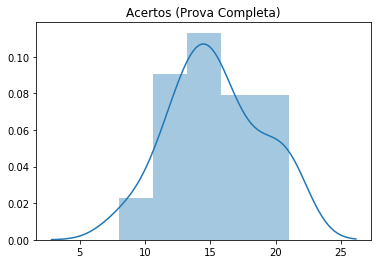

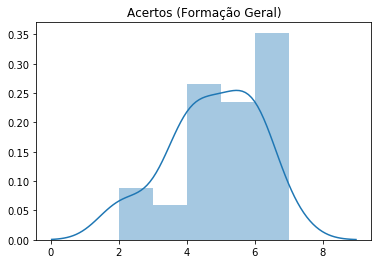

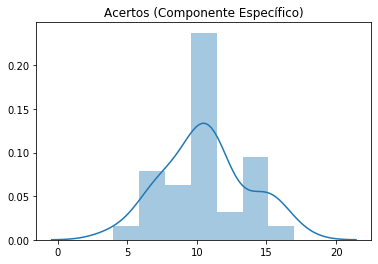

,Média Acertos,Desvio Padrão Acertos,Mediana Acertos,Skewness Acertos,Kurtosis Acertos,Moda Acertos,Nota %,Nº Questões Válidas
Prova Completa,15.38,3.52,15.0,0.07,-0.56,15,48.07,32
Formação Geral,4.76,1.35,5.0,-0.49,-0.33,6,59.56,8
Componente Específico,10.62,3.04,11.0,0.15,-0.26,11,44.24,24


In [18]:

def get_general_stats_df(df: pd.DataFrame, subject_df: pd.DataFrame, year: int):
    
    subject_df_year = subject_df.loc[subject_df["ano"] == year]
    
    objective_argument = subject_df_year["tipoquestao"] == "Objetiva"
    

    def get_general_statistics(df: pd.DataFrame, questions: List[int]) -> List[float]:
        
        status_relevant_questions = df[[f"QUESTAO_{i}_STATUS" for i in questions]].copy()
        valid_questions = status_relevant_questions.loc[:, (status_relevant_questions.iloc[0] != CANCELLED_LABEL)].columns
        valid_questions = [int(x[len("QUESTAO_"):-len("_STATUS")]) for x in valid_questions]
    
        relevant_columns = df[[f"QUESTAO_{i}_NOTA" for i in valid_questions]].copy()
        relevant_columns = relevant_columns.replace([BLANK_LABEL, DELETION_LABEL], 0)
        relevant_columns = relevant_columns.astype(int)
        relevant_columns = relevant_columns / 100
        data = relevant_columns.sum(axis=1)
        mean_acertos = data.mean()
        median_acertos = data.median()
        std_acertos = data.std()
        skew_acertos = data.skew()
        kurtosis_acertos = data.kurtosis()
        mode_acertos = data.mode().astype(int)
        mode_acertos = mode_acertos.astype(str)
        mode_acertos = ", ".join(mode_acertos.tolist())

        return [mean_acertos, std_acertos, median_acertos, skew_acertos, kurtosis_acertos,
                            len(valid_questions)], mode_acertos, data

    modes = []
    index = ["Prova Completa", "Formação Geral", "Componente Específico"]
    columns = ["Média Acertos", "Desvio Padrão Acertos", "Mediana Acertos", 
                              "Skewness Acertos", "Kurtosis Acertos", "Nº Questões Válidas"]
    data = np.zeros((len(index), len(columns)), dtype=float)
    data_to_plot = []
    general_index = subject_df_year["prova"] == "Geral"
    specific_index = subject_df_year["prova"] == "Específica"
    questions_lists = [subject_manipulation.get_objective_questions(subject_df_year), # questões objetivas
                       subject_df_year.loc[objective_argument & general_index]["idquestao"].tolist(), #objetivas e de formação geral
                       subject_df_year.loc[objective_argument & specific_index]["idquestao"].tolist()] #objetivas de de formação especifica

    for type_exam_index, question_list in enumerate(questions_lists):
        data[type_exam_index], new_mode, new_data_to_plot = get_general_statistics(df, question_list)
        modes.append(new_mode)
        data_to_plot.append(new_data_to_plot)
    

    exam_df = pd.DataFrame(columns=columns, data=data, index=index)
    exam_df["Moda Acertos"] = modes
    exam_df["Nº Questões Válidas"] = exam_df["Nº Questões Válidas"].astype(int)
    exam_df["Nota %"] = exam_df["Média Acertos"] * 100 / exam_df["Nº Questões Válidas"]
    columns_without_num_questions = list(exam_df.columns)
    columns_without_num_questions.remove("Nº Questões Válidas")
    exam_df = exam_df[columns_without_num_questions + ["Nº Questões Válidas"]]

    return exam_df.round(2), data_to_plot

general_stats_dfs = {}
data_to_plot = {}

for year in dfs.keys():
    df = dfs[year].copy()
    general_stats_df, new_data_to_plot = get_general_stats_df(df, subject_df, year)
    general_stats_dfs[year] = general_stats_df
    data_to_plot[year] = new_data_to_plot

def plot_histogram(data_to_plot_year):
    labels = ["Prova Completa", "Formação Geral", "Componente Específico"]
    for data, label in zip(data_to_plot_year, labels):
        sns.distplot(data)
        plt.title(f"Acertos ({label})")
        plt.show()
    
year = 2017
print(f"Ano de {year}")
plot_histogram(data_to_plot[year])
general_stats_dfs[year]




Ano de 2014


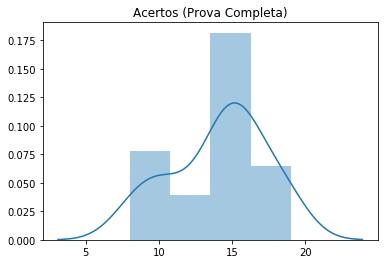

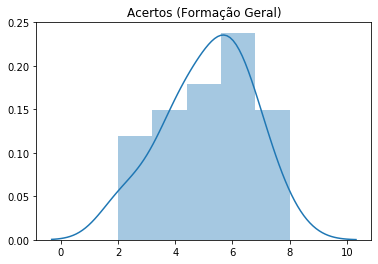

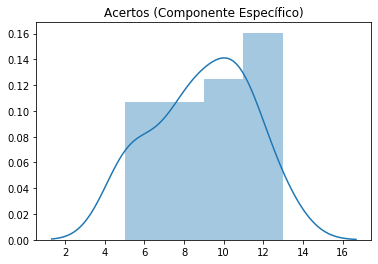

,Média Acertos,Desvio Padrão Acertos,Mediana Acertos,Skewness Acertos,Kurtosis Acertos,Moda Acertos,Nota %,Nº Questões Válidas
Prova Completa,14.07,3.23,15.0,-0.42,-0.70,"15, 16",48.52,29
Formação Geral,5.14,1.53,5.0,-0.39,-0.31,6,64.29,8
Componente Específico,8.93,2.43,9.0,-0.23,-0.89,11,42.52,21


In [19]:
year = 2014
print(f"Ano de {year}")
plot_histogram(data_to_plot[year])
general_stats_dfs[year]

Ano de 2011


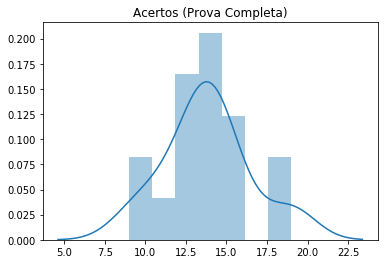

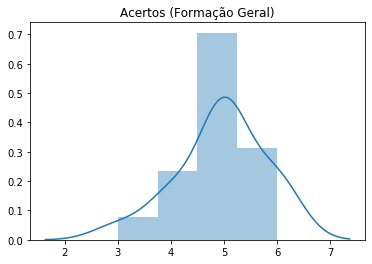

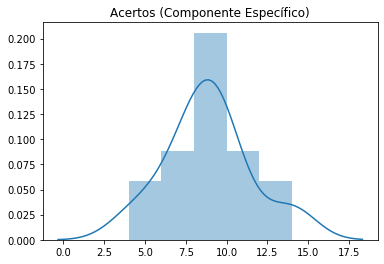

,Média Acertos,Desvio Padrão Acertos,Mediana Acertos,Skewness Acertos,Kurtosis Acertos,Moda Acertos,Nota %,Nº Questões Válidas
Prova Completa,13.82,2.65,14.0,0.35,0.57,14,47.67,29
Formação Geral,4.94,0.83,5.0,-0.63,0.55,5,61.76,8
Componente Específico,8.88,2.62,9.0,0.33,0.66,9,42.30,21


In [20]:
year = 2011
print(f"Ano de {year}")
plot_histogram(data_to_plot[year])
general_stats_dfs[year]

Ano de 2008


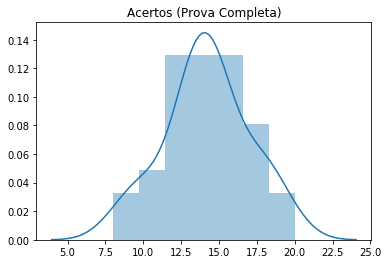

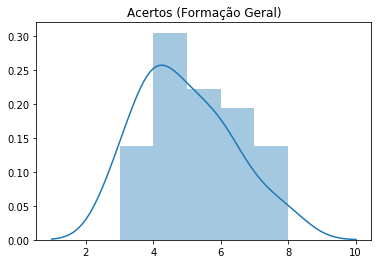

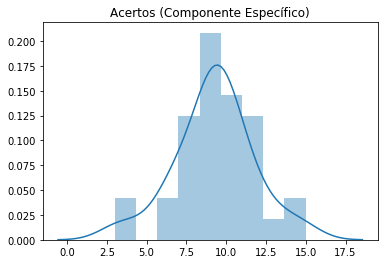

,Média Acertos,Desvio Padrão Acertos,Mediana Acertos,Skewness Acertos,Kurtosis Acertos,Moda Acertos,Nota %,Nº Questões Válidas
Prova Completa,14.19,2.81,14.0,-0.10,-0.10,14,40.56,35
Formação Geral,4.94,1.39,5.0,0.51,-0.42,4,61.81,8
Componente Específico,9.25,2.47,9.0,-0.18,0.92,9,34.26,27


In [21]:
year = 2008
print(f"Ano de {year}")
plot_histogram(data_to_plot[year])
general_stats_dfs[year]

Ano de 2005


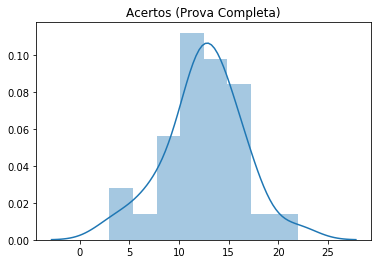

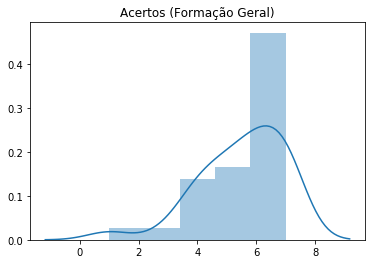

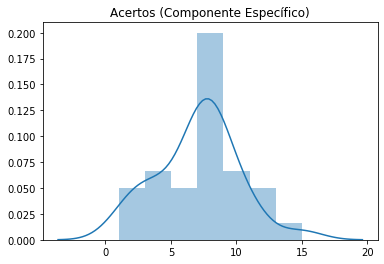

,Média Acertos,Desvio Padrão Acertos,Mediana Acertos,Skewness Acertos,Kurtosis Acertos,Moda Acertos,Nota %,Nº Questões Válidas
Prova Completa,12.53,3.91,12.5,-0.23,0.92,12,43.22,29
Formação Geral,5.50,1.46,6.0,-1.11,1.58,7,78.57,7
Componente Específico,7.03,3.09,7.5,0.07,0.46,8,31.97,22


In [22]:
year = 2005
print(f"Ano de {year}")
plot_histogram(data_to_plot[year])
general_stats_dfs[year]

In [23]:
display_all_years_nota(general_stats_dfs)

,2005,2008,2011,2014,2017
Prova Completa,43.22,40.56,47.67,48.52,48.07
Formação Geral,78.57,61.81,61.76,64.29,59.56
Componente Específico,31.97,34.26,42.30,42.52,44.24


In [24]:

def get_all_years_score(dfs: dict, subject_df: pd.DataFrame, years: List[int]):
  
    def auxiliar_function(df: pd.DataFrame, questions: List[int]) -> List[float]:
        
        status_relevant_questions = df[[f"QUESTAO_{i}_STATUS" for i in questions]].copy()
        valid_questions = status_relevant_questions.loc[:, (status_relevant_questions.iloc[0] != CANCELLED_LABEL)].columns
        valid_questions = [int(x[len("QUESTAO_"):-len("_STATUS")]) for x in valid_questions]
        
        relevant_columns = df[[f"QUESTAO_{i}_NOTA" for i in valid_questions]].copy()
        relevant_columns = relevant_columns.replace([BLANK_LABEL, DELETION_LABEL], 0)
        relevant_columns = relevant_columns.astype(int)
        relevant_columns = relevant_columns / 100
        data = relevant_columns.sum(axis=1)
        correct_answered = data.sum()
        
        num_alunos = df.shape[0]
        answered = len(valid_questions) * num_alunos

        return [correct_answered, answered]


    all_year_general_score_dfs = []
    for year in years:
        df = dfs[year]
        
        subject_df_year = subject_df.loc[subject_df["ano"] == year]
    
        objective_argument = subject_df_year["tipoquestao"] == "Objetiva"
    
    
        index = ["Prova Completa", "Formação Geral", "Componente Específico"]
        columns = ["Numero Acertos", "Total de Questões Respondidas"]
        data = np.zeros((len(index), len(columns)), dtype=float)
        questions_lists = [subject_manipulation.get_objective_questions(subject_df_year),
                       subject_df_year.loc[objective_argument & (subject_df_year["prova"] == "Geral")]["idquestao"].tolist(),
                       subject_df_year.loc[objective_argument & (subject_df_year["prova"] == "Específica")]["idquestao"].tolist()]

        for type_exam_index, question_list in enumerate(questions_lists):
            data[type_exam_index] = auxiliar_function(df, question_list)
    
        year_general_score_df = pd.DataFrame(columns=columns, data=data, index=index)
        all_year_general_score_dfs.append(year_general_score_df)
        
    output_df = all_year_general_score_dfs[0]
    for df in all_year_general_score_dfs[1:]:
        output_df = output_df.add(df)
    
    output_df = output_df.astype(int)
    output_df["Nota %"] = output_df["Numero Acertos"] * 100 / output_df["Total de Questões Respondidas"]
    
    return output_df.round(2)
print("Dados de todos os anos considerando todos os alunos")
get_all_years_score(dfs, subject_df, dfs.keys())

Dados de todos os anos considerando todos os alunos


,Numero Acertos,Total de Questões Respondidas,Nota %
Prova Completa,2039,4523,45.08
Formação Geral,733,1130,64.87
Componente Específico,1306,3393,38.49


In [25]:
difficulty_df = pd.read_csv("data/dificuldade_questao.csv")

In [26]:
def get_display_df_difficulty(year: int, input_df: pd.DataFrame,
                              difficulty_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
   
    temp_difficulty_df = difficulty_df.loc[difficulty_df['ano'] == year].copy()
    
    util.map_presence(input_df)
    presence_df = input_df["TP_PRES"].value_counts()
    
    input_df = util.filter_present_students(input_df)
    
    input_df = util.add_all_score_categories(input_df, temp_difficulty_df, True,
                                             DIFFICULTIES, util.get_difficulty_valid_questions)
        
    categories = DIFFICULTIES
    
    num_questions = []
    mean_acertos = []
    std_acertos = []
    column_zero = []
    column_geq_one = []
    column_all = []
    num_alunos = input_df.shape[0]

    
    for category in categories:
        questions = util.get_difficulty_valid_questions(category, 
                                                             temp_difficulty_df,
                                                             input_df)
        num_obj_questions = len(questions)
    
        mean_acertos_category = input_df[f"ACERTOS_OBJ_{category}"].mean()
    
        std_acertos_category = input_df[f"ACERTOS_OBJ_{category}"].std()
        
        zero_category_percentage = list(input_df[f"ACERTOS_OBJ_{category}"]).count(0) * 100 / num_alunos
    
        geq_one_category_percentage = list(input_df[f"ACERTOS_OBJ_{category}"] >= 1).count(True) * 100 / num_alunos
        
        all_category_percentage = list(input_df[f"ACERTOS_OBJ_{category}"] == num_obj_questions).count(True) * 100 / num_alunos
        
        if num_obj_questions > 0:
            num_questions.append(num_obj_questions)
            mean_acertos.append(mean_acertos_category)
            std_acertos.append(std_acertos_category)
            column_zero.append(zero_category_percentage)
            column_geq_one.append(geq_one_category_percentage)
            column_all.append(all_category_percentage)
        else:
            num_questions.append(0)
            mean_acertos.append(None)
            std_acertos.append(None)
            column_zero.append(None)
            column_geq_one.append(None)
            column_all.append(None)

    category_labels = [f"SCORE_OBJ_{x}" for x in categories]

    mean_by_category = input_df[category_labels].mean().values

    data = np.array([mean_by_category, num_questions]).T

    display_df = pd.DataFrame(data=data, index=categories, 
                          columns=["Nota %", "Nº Questões"])
    display_df["Nº Questões"] = display_df["Nº Questões"].astype(int, errors="ignore")
    display_df["Média Acertos"] = mean_acertos
    display_df["Desvio Padrão Acertos"] = std_acertos
    display_df["% de Zeros"] = column_zero

    display_df["% de Alunos que acertaram pelo menos uma questão"] = column_geq_one
    display_df["% de Alunos que acertaram todas"] = column_all


    display_df = display_df.sort_values(by=["Nota %"]).round(2)

    
    return display_df, input_df


In [27]:
enade_all_years_ufpa = get_dict_all_years(filter_by_ufpa=True)
enade_all_years_br = get_dict_all_years(filter_by_ufpa=False)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (1,5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (49,55,58,68) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (67,68,69,70,71,72,73,74,76,77,78,79,80,81,85) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (1,5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (49,55,58,68) have mixed types.Specify dtype option on import or set low_memory=False.
 

In [28]:
def get_display_dfs_difficulty(enade_all_years_dict: dict) -> dict:
    result = {}
    for year in enade_all_years_dict.keys():
        display_df, enade_all_years_dict[year] = get_display_df_difficulty(year,
                                                                           enade_all_years_dict[year],
                                                                           difficulty_df)
        result[year] = display_df
    return result

display_dfs_difficulty_ufpa = get_display_dfs_difficulty(enade_all_years_ufpa)
display_dfs_difficulty_br = get_display_dfs_difficulty(enade_all_years_br)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [29]:

print("UFPA - 2017")
display_dfs_difficulty_ufpa[2017]

UFPA - 2017


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
dificil,31.83,17,5.41,2.16,0.00,100.00,0.00
medio,54.41,8,4.35,1.63,0.00,100.00,0.00
facil,77.45,6,4.65,1.01,0.00,100.00,20.59
muito facil,97.06,1,0.97,0.17,2.94,97.06,97.06
muito dificil,NaN,0,NaN,NaN,NaN,NaN,NaN


In [30]:
print("Brasil - 2017")
display_dfs_difficulty_br[2017]


Brasil - 2017


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
dificil,31.46,17,5.35,2.52,0.85,99.15,0.00
medio,51.28,8,4.10,1.70,1.35,98.65,1.48
facil,68.18,6,4.09,1.40,1.18,98.82,15.68
muito facil,87.56,1,0.88,0.33,12.44,87.56,87.56
muito dificil,NaN,0,NaN,NaN,NaN,NaN,NaN


In [31]:
print("UFPA - 2014")
display_dfs_difficulty_ufpa[2014]

UFPA - 2014


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
muito dificil,17.86,1,0.18,0.39,82.14,17.86,17.86
dificil,28.57,12,3.43,1.26,0.00,100.00,0.00
medio,46.43,6,2.79,1.20,3.57,96.43,0.00
facil,76.79,10,7.68,1.70,0.00,100.00,10.71
muito facil,NaN,0,NaN,NaN,NaN,NaN,NaN


In [32]:
print("Brasil - 2014")

display_dfs_difficulty_br[2014]

Brasil - 2014


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
muito dificil,14.27,1,0.14,0.35,85.73,14.27,14.27
dificil,30.47,12,3.66,1.96,2.50,97.50,0.02
medio,52.39,6,3.14,1.42,2.68,97.32,4.76
facil,71.62,10,7.16,2.04,0.36,99.64,10.78
muito facil,NaN,0,NaN,NaN,NaN,NaN,NaN


In [33]:
print("UFPA - 2011")
display_dfs_difficulty_ufpa[2011]

UFPA - 2011


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
muito dificil,5.88,2,0.12,0.33,88.24,11.76,0.00
dificil,37.02,17,6.29,2.20,0.00,100.00,0.00
medio,68.63,6,4.12,1.17,0.00,100.00,11.76
facil,82.35,4,3.29,0.59,0.00,100.00,35.29
muito facil,NaN,0,NaN,NaN,NaN,NaN,NaN


In [34]:
print("Brasil - 2011")

display_dfs_difficulty_br[2011]

Brasil - 2011


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
muito dificil,15.20,2,0.30,0.50,71.74,28.26,2.15
dificil,26.99,17,4.59,2.46,2.44,97.56,0.00
medio,47.27,6,2.84,1.44,5.52,94.48,2.24
facil,70.32,4,2.81,1.11,4.45,95.55,31.56
muito facil,NaN,0,NaN,NaN,NaN,NaN,NaN


In [35]:
print("UFPA - 2008")
display_dfs_difficulty_ufpa[2008]

UFPA - 2008


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
muito dificil,19.44,4,0.78,0.87,41.67,58.33,2.78
dificil,31.39,20,6.28,2.02,0.00,100.00,0.00
medio,56.94,8,4.56,1.18,0.00,100.00,0.00
facil,86.11,3,2.58,0.50,0.00,100.00,58.33
muito facil,NaN,0,NaN,NaN,NaN,NaN,NaN


In [36]:
print("Brasil - 2008")

display_dfs_difficulty_br[2008]

Brasil - 2008


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
muito dificil,15.18,4,0.61,0.82,56.73,43.27,0.50
dificil,29.92,20,5.98,2.86,2.11,97.89,0.00
medio,55.58,8,4.45,1.70,1.90,98.10,2.22
facil,76.29,3,2.29,0.86,4.80,95.20,50.79
muito facil,NaN,0,NaN,NaN,NaN,NaN,NaN


In [37]:
print("UFPA - 2005")
display_dfs_difficulty_ufpa[2005]

UFPA - 2005


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
muito dificil,15.00,2,0.30,0.47,70.00,30.00,0.00
dificil,28.82,17,4.90,2.62,3.33,96.67,0.00
medio,62.67,5,3.13,1.07,0.00,100.00,10.00
facil,81.67,4,3.27,0.91,0.00,100.00,53.33
muito facil,93.33,1,0.93,0.25,6.67,93.33,93.33


In [38]:
print("Brasil - 2005")

display_dfs_difficulty_br[2005]

Brasil - 2005


,Nota %,Nº Questões,Média Acertos,Desvio Padrão Acertos,% de Zeros,% de Alunos que acertaram pelo menos uma questão,% de Alunos que acertaram todas
muito dificil,14.07,2,0.28,0.50,74.34,25.66,2.48
dificil,28.06,17,4.77,2.73,4.32,95.68,0.00
medio,55.40,5,2.77,1.33,5.69,94.31,9.46
facil,76.91,4,3.08,1.05,3.37,96.63,43.76
muito facil,90.53,1,0.91,0.29,9.47,90.53,90.53


In [39]:
print("Nota % por ano - UFPA")
display_all_years_nota(display_dfs_difficulty_ufpa)

Nota % por ano - UFPA


,2005,2008,2011,2014,2017
dificil,28.82,31.39,37.02,28.57,31.83
facil,81.67,86.11,82.35,76.79,77.45
medio,62.67,56.94,68.63,46.43,54.41
muito dificil,15.00,19.44,5.88,17.86,NaN
muito facil,93.33,NaN,NaN,NaN,97.06


In [40]:
print("Nota % por ano - Brasil")
display_all_years_nota(display_dfs_difficulty_br)

Nota % por ano - Brasil


,2005,2008,2011,2014,2017
dificil,28.06,29.92,26.99,30.47,31.46
facil,76.91,76.29,70.32,71.62,68.18
medio,55.40,55.58,47.27,52.39,51.28
muito dificil,14.07,15.18,15.20,14.27,NaN
muito facil,90.53,NaN,NaN,NaN,87.56


In [41]:
print("Brasil")
get_all_years_combined_df(display_dfs_difficulty_br, enade_all_years_br, DIFFICULTIES)

Brasil


,Questões Respondidas no total (Questões x Alunos),Acertos no Total (Acertos x Alunos),Nota %
muito dificil,67136,9972,14.85
dificil,653901,191384,29.27
medio,261690,135981,51.96
facil,219259,157094,71.65
muito facil,15223,13529,88.87


In [42]:
print("UFPA")
get_all_years_combined_df(display_dfs_difficulty_ufpa, enade_all_years_ufpa, DIFFICULTIES)

UFPA


,Questões Respondidas no total (Questões x Alunos),Acertos no Total (Acertos x Alunos),Nota %
muito dificil,266,44,16.54
dificil,2433,760,31.24
medio,980,554,56.53
facil,780,620,79.49
muito facil,64,61,95.31
